### Self-Study Try-It Activity 14.1: Grid Searching Decision Trees 


This try-it focuses on performing a grid search with a `DecisionTreeClassifier`.  As mentioned in the lectures, the grid search for a tree model can get large very easily. In addition to using `GridSearchCV`, scikitlearn implements additional tools that can save energy and offer alternatives to the brute force exhaustive search.  Below, you will compare the performance of some of these alternatives and discuss the time these searches take.  Note that this will be in large part determined by your personal computing power however the relative speed of the searches should be consistent.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_halving_search_cv
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.preprocessing import LabelEncoder

import time

In [2]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

In [3]:
whickham_data = pd.read_csv('data/Whickham.txt')
whickham_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   outcome  1314 non-null   object
 1   smoker   1314 non-null   object
 2   age      1314 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 30.9+ KB


Encode the categorical feature `smoke` and `outcome`

In [4]:
encoder = LabelEncoder()
whickham_data['smoker'] = encoder.fit_transform(whickham_data['smoker'])
whickham_data['outcome'] = encoder.fit_transform(whickham_data['outcome'])


Split data into training and testing

In [5]:
X = whickham_data[['smoker', 'age']]
y = whickham_data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)



Initiallizing all the grid search cv classifiers

Note:
factor: The reduction factor that determines the rate at which the number of candidates is reduced at each iteration.
 - A higher factor means faster reduction and fewer iterations. 
 - In this case, 'factor=2' halves the number of candidates in each iteration.

 min_resources: The minimum amount of resource that is allocated to any given candidate. 
 - 'min_resources="smallest"' means that the smallest amount that allows for a meaningful result 
 - will be used. This could be the smallest number of samples necessary to fit a model, 
 - ensuring that at least a few candidates are evaluated at each iteration.


In [6]:
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=5, scoring='accuracy')
halving_grid_search = HalvingGridSearchCV(estimator=dtree, param_grid=param_grid, cv=5, scoring='accuracy', random_state=42)

random_search = RandomizedSearchCV(estimator=dtree, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=42)
halving_random_search = HalvingRandomSearchCV(estimator=dtree, param_distributions=param_grid, cv=5, scoring='accuracy', random_state=42)

### Comparing Grid Searches

Below, explore the four grid search options using the same parameter selections for the `DecisionTreeClassifier`. All of the grid searching tools have a `.cv_results_` attribute after fitting that contains information after fitting including time.  Use this to compare the time of each search and discuss what you believe the "best" approach to identifying the hyperparameters of the model are between:

- `GridSearchCV`
- `RandomizedSearchCV`
- `HalvingGridSearchCV`
- `HalvingRandomSearchCV`

Share your results in a plot comparing the different times for searching across the different parameters as well as the score of the different estimators that resulted from the grid search.  

We will also use time to keep track of how long it train!

In [7]:
start_time_gs = time.time()
grid_search.fit(X_train, y_train)
end_time_gs = time.time()

start_time_hgs = time.time()
halving_grid_search.fit(X_train, y_train)
end_time_hgs = time.time()

start_time_rs = time.time()
random_search.fit(X_train, y_train)
end_time_rs = time.time()

start_time_hrs = time.time()
halving_random_search.fit(X_train, y_train)
end_time_hrs = time.time()

Collecting all the stats

In [8]:
results = {
    'GridSearchCV': {
        'Best Score': grid_search.best_score_,
        'Best Params': grid_search.best_params_,
        'Time Taken': end_time_gs - start_time_gs
    },
    'HalvingGridSearchCV': {
        'Best Score': halving_grid_search.best_score_,
        'Best Params': halving_grid_search.best_params_,
        'Time Taken': end_time_hgs - start_time_hgs
    },
    'RandomizedSearchCV': {
        'Best Score': random_search.best_score_,
        'Best Params': random_search.best_params_,
        'Time Taken': end_time_rs - start_time_rs
    },
    'HalvingRandomSearchCV': {
        'Best Score': halving_random_search.best_score_,
        'Best Params': halving_random_search.best_params_,
        'Time Taken': end_time_hrs - start_time_hrs
    }
}

In [9]:
df_results = pd.DataFrame.from_dict(results, orient='index')
pd.set_option('display.max_colwidth', None)

In [10]:
df_results

,Best Score,Best Params,Time Taken
GridSearchCV,0.843006,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2}",1.972736
HalvingGridSearchCV,0.802181,"{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}",3.545639
RandomizedSearchCV,0.843006,"{'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': None, 'criterion': 'entropy'}",1.872520
HalvingRandomSearchCV,0.802181,"{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'entropy'}",1.761531


Let's visuallize all the fitting time to see which search yield the best performance fastest.

In [11]:
methods = ['GridSearchCV', 'HalvingGridSearchCV', 'RandomizedSearchCV', 'HalvingRandomSearchCV']
times = [results[method]['Time Taken'] for method in methods]
scores = [results[method]['Best Score'] for method in methods]

# these variables are just retrieve the times and score for each CV methods from the results dictionaries

In [12]:
scores

[0.8430060934326338,
 0.8021806853582554,
 0.8430060934326338,
 0.8021806853582554]

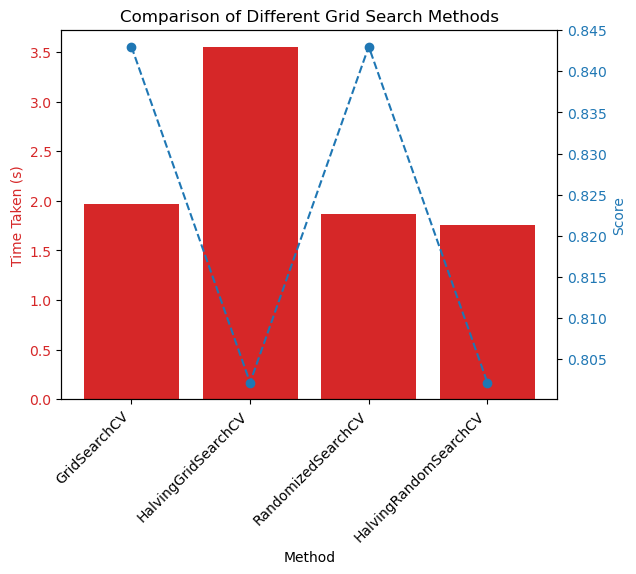

In [13]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Method')
ax1.set_ylabel('Time Taken (s)', color=color)
ax1.bar(methods, times, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels(methods, rotation=45, ha='right')

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Score', color=color)
ax2.plot(methods, scores, color=color, marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Comparison of Different Grid Search Methods')
plt.show()